## Formatting the data
The data available is not perfect. Some articles have missing information. Such texts will be filtered out - The data will be loaded from a JSON and converted to a Pandas dataframe. 

The necessary features are: __Domain, Body, Header__ and __Byline__. URI is nice to have, but not necessary.

Author: lkt259@alumni.ku.dk

In [156]:
import numpy as np
import pandas as pd
import os, re
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from scipy.stats.stats import pearsonr
plt.style.use('seaborn')

In [157]:
#Load data - and show 120 characters of the body.
data = pd.read_json(r'data/data_0.json')
pd.set_option('display.max_colwidth', 220)
data.head(3)

,Id,Domain,Body,Header,PublicationDate,Uri,Byline,TextHash
0,842325,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . FOR ABONNENTER »Der var ov...,Utilfreds passager: »Prøv selv en tur klokken 7.30 en hverdagsmorgen« - politiken.dk,2002-09-17T00:00:00,https://politiken.dk/forbrugogliv/art6088327/Utilfreds-passager-%C2%BBPr%C3%B8v-selv-en-tur-klokken-7.30-en-hverdagsmorgen%C2%AB,Annemette Grundtvig,-346867430
1,842324,politiken.dk,"Klimamonitor Byrummonitor Skolemonitor Sundhedsmonitor Kulturmonitor Følg os Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« For to år siden fik forfatter ...","Minimalist: »Ofte står jeg og mangler en ting og bliver irriteret på mig selv over, at jeg har smidt den ud« - politiken.dk",2013-01-18T00:00:00,https://politiken.dk/forbrugogliv/art6287464/%C2%BBOfte-st%C3%A5r-jeg-og-mangler-en-ting-og-bliver-irriteret-p%C3%A5-mig-selv-over-at-jeg-har-smidt-den-ud%C2%AB,Annemette Grundtvig,-1346564151
2,842323,politiken.dk,Læs artiklen senere Gemt (klik for at fjerne) Læst Giv artiklen videre Som abonnent kan du ubegrænset dele artikler med dine venner og familie. Læs mere om fordelene ved et abonnement her . Køb abonnement Den familie...,Digitalt forældreskab: Hvilken type er du som Facebook-forælder? - politiken.dk,2006-05-17T00:00:00,https://politiken.dk/forbrugogliv/art5934818/Hvilken-type-er-du-som-Facebook-for%C3%A6lder,Annemette Grundtvig,1473032676


### Removing duplicates and empty bodies
We don't want duplicate articles. First, we'll remove entries with the same URI and body. I save the entries, which have empty bodies and unique URI's - Perhaps we can get the body online, if needed.

In [158]:
def same_uri(uri):
    return data[data['Uri']==uri]

def remove_duplicates(data):
    print("With duplicates:", data.shape)
    data = data.drop_duplicates(subset=["Body", "Uri"]) #Remove entries with same body and URI
    empty_bodies = data[data['Body'] == '']    #Save empty bodied entries in another dataframe.
    data = data[data['Body'] != '']
    empty_bodies = empty_bodies[~empty_bodies['Uri'].isin(data['Uri'])] #Remove empty bodies, which are present in data.
    duplicate_bodies = data[data.duplicated(subset=["Body"])]
    data = data.drop_duplicates(subset=['Body']) #Can remove all duplicate bodies here, after None-bodies are removed.
    
    print("Without duplicates:", data.shape)
    return data, empty_bodies, duplicate_bodies

data, _, _ = remove_duplicates(data)

With duplicates: (10000, 8)
Without duplicates: (9074, 8)


### Removing unknown authors, headers and domains

In [159]:
def remove_missing_feats(data):
    no_author, no_header, no_domain = None, None, None
    
    if data['Byline'].isnull().values.any(): #Missing authors
        no_author = data[data['Byline'].isnull()]
        data = data.dropna(subset=['Byline'])
        print("Without unknown authors:", data.shape)

    if data['Header'].isnull().values.any():
        no_header = data[data['Header'].isnull()]
        data = data.dropna(subset=['Header'])
        print("Without unknown title:", data.shape)

    if data['Domain'].isnull().values.any():
        no_domain = data[data['Domain'].isnull()]
        data = data.dropna(subset=['Domain'])
        print("Without unknown domains:", data.shape)
        
    return data, no_author, no_header, no_domain

data, _, _, _ = remove_missing_feats(data)

Without unknown authors: (9073, 8)


### Applying to all data files.
After investigating the data, let's apply the changes to the files. No need in formatting multiple times. Also, let's see how the distributions are when collecting all data.

In [160]:
#Load all data into one big dataframe. Oh yes, it is possible!
files = os.listdir('data')
files = [x for x in files if x[-4:]=='json'] #only take .json files.

data = pd.read_json('data/'+files[0])
for file in tqdm(files[1:]):
    data = pd.concat([data, pd.read_json('data/'+file)])
data.shape

  0%|          | 0/80 [00:00<?, ?it/s]

(808066, 8)

#### How much data is lost?
Some data did not meet the requirements. How much data do we have left?

In [161]:
data, empty_bodies, duplicate_bodies = remove_duplicates(data)
data, no_author, no_header, no_domain = remove_missing_feats(data)

#Removing bad authors. Baaad author, shame on you!
bad_byline = data[data['Byline']==data['Uri']]
data = data[data['Byline']!=data['Uri']]
print("With bad authors removed:", data.shape)

With duplicates: (808066, 8)
Without duplicates: (530031, 8)
Without unknown authors: (495099, 8)
With bad authors removed: (447939, 8)


In [162]:
print("Unique authors: ", len(data['Byline'].value_counts()))
print(data['Byline'].value_counts()[:5],"\n...")

Unique authors:  8260
Mads Elkær               53835
Anne Sophia Hermansen    15481
Karim Pedersen           14066
Thomas Treo               9434
Dan Jensen                6915
Name: Byline, dtype: int64 
...


In [163]:
print(len(empty_bodies), "empty bodies")
print(len(no_author), "without author")
#print(len(no_header), "without header")
#print(len(no_domain), "without domain")
print(len(bad_byline), "malformed authors")

448 empty bodies
34932 without author
47160 malformed authors


### Author cleanup!
Some entries have multiple auhthors. How big a problem does this cause?

In [168]:
authors = list(data['Byline'])[1:] #First entry is empty.
multiple_authors_candidates = []
for author in authors:
    if any(x in author for x in ['|',',']):
        multiple_authors_candidates.append(author)

print("Entries with multiple authors (and titles, cities):" ,len(multiple_authors_candidates))
print(f"Unique combinations of authors: {len(set(multiple_authors_candidates))}")

#multiple_authors = [re.split('\||,',x) for x in multiple_authors]

Entries with multiple authors (and titles, cities): 12471
Unique combinations of authors: 5112


**Now! Let us remove entries with multiple authors.**

Some authors are actually not multiple authors, but cities and titles. These entries will be kept, but stripped from everything except the name. We don't want multiple authors, as this project focuses on single authors.

In [10]:
#Read txt file with words that should not be masked.
with open('data/additional/author_filter.txt', encoding='utf-8') as f:
    lst = f.read()
    lst = lst.split('\n')

author_filter = lst

print(f"{len(set([x for x in multiple_authors_candidates if '|' in x]))} authors removed by '|-rule'")
bar_rule = [x for x in multiple_authors_candidates if '|' in x]
multiple_authors_candidates = [x for x in multiple_authors_candidates if '|' not in x] #Remove entries with | in them.

new_authors_candidates = []
author_names_without_city = [] #Save the new, stripped name and the old one, to edit data fterwards.

for candidate in multiple_authors_candidates:
    names = candidate.split(',') #Split by , to separate authors or cities    
    
    append = True
    
    #Loop through names
    for name in names:
        name = name.strip()
        if len(name.split())>1: #Name is not two or more names.
            if any(ele in name for ele in author_filter): #Do not append if name found in filter.
                append = False
        else:
            append = False
    
    if append:
        new_authors_candidates.append(candidate)
    else:
        #Append to names list without cities. 
        if any(ele in names[0] for ele in author_filter): #If first name appears in filter, use second name.
            author_names_without_city.append((names[1], candidate))
        else:
            author_names_without_city.append((names[0], candidate))
            
print(f"{len(set(new_authors_candidates))} author combinations removed by filter.")
print(f"Kept {len(set([x[0] for x in author_names_without_city]))} authors (Not sure if they are new authors yet).")

already_there_hon = 0
uniques = data['Byline'].unique()
for i in set([x[0] for x in author_names_without_city]):
    if i in uniques:
        already_there_hon += 1
        
print(f"{already_there_hon} authors already present in data by themselves.")

3042 authors removed by '|-rule'
1664 author combinations removed by filter.
Kept 226 authors (Not sure if they are new authors yet).
143 authors already present in data by themselves.


In [11]:
#Drop multiple authors from data.
data = data[data['Byline'].isin(new_authors_candidates) == False]
data = data[data['Byline'].isin(bar_rule) == False]

#Convert wrong names to right names in data.
print("Converting names...")
for entry in tqdm(author_names_without_city):
    name = entry[0]
    wrong_name = entry[1]
    
    data.loc[data["Byline"] == wrong_name, "Byline"] = name
print("Names are converted! That was slow.")

Converting names...


  0%|          | 0/1514 [00:00<?, ?it/s]

Names are converted! That was slow.


# Insights in data

### Body lengths
Let's see the distribution of the body lengths.

Text(0, 0.5, 'Article count')

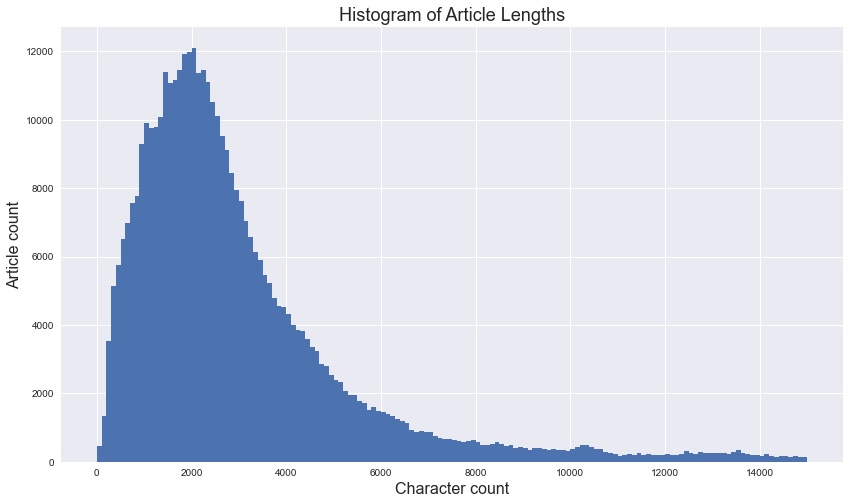

In [12]:
body_lengths = data['Body'].str.len()

desc = "A dent in article counts at 250 characters\nNot true"

y, bin_edges = np.histogram(body_lengths, bins=150, range=(0,15000))
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges))
plt.title("Histogram of Article Lengths", fontsize=18)
plt.xlabel("Character count", fontsize=16)
plt.ylabel("Article count", fontsize=16)
#plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
#plt.plot([250,10000], [30,240], '--', c='red', alpha=.6)
#Ændr, så det passer med den endelige data.

### Author contributions
How many articles have the authors written?

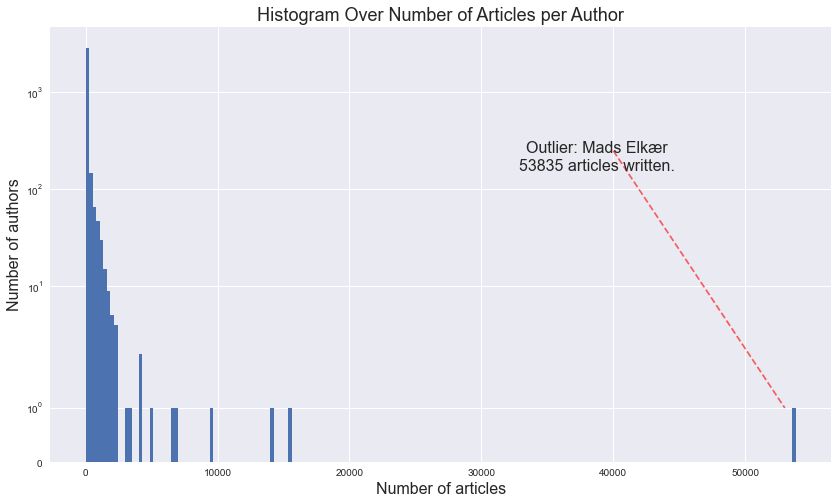

In [13]:
counts = list(data['Byline'].value_counts())

# plt.yscale('symlog')
# plt.xlim(-100,4000)

y, bin_edges = np.histogram(counts, bins=200)
x = 0.5*(bin_edges[1:] + bin_edges[:-1])

fig, ax = plt.subplots(1, figsize=(14,8))
plt.bar(x,y,width=np.diff(bin_edges))

plt.yscale('symlog')
plt.title("Histogram Over Number of Articles per Author", fontsize=18)
plt.xlabel("Number of articles", fontsize=16)
plt.ylabel("Number of authors", fontsize=16)

desc = "Outlier: Mads Elkær\n53835 articles written."
plt.text(0.7, 0.7, desc, horizontalalignment='center',verticalalignment='center', transform=ax.transAxes, fontsize=16)
plt.plot([40000,53000], [250,1], '--', c='red', alpha=.6)

### Author body length
Do authors have certain body lengths? In articles, not their actual bodies. Let us make a plot to see if there is a correlation between article count and body length. But first, we need to find the average body length per author. 

In [46]:
df = pd.DataFrame(columns=['body_length', 'author'])
df['body_length'] = body_lengths
df['author'] = data['Byline']
df['author'].replace('', np.nan, inplace=True)
df = df.dropna()
avg_body_lengths = list(df.groupby(['author']).mean()['body_length'])

Text(0, 0.5, 'Number of authors')

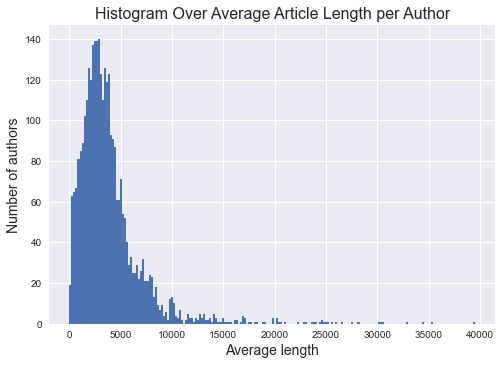

In [47]:
plt.hist(avg_body_lengths, bins=200);
plt.title("Histogram Over Average Article Length per Author", fontsize=16)
plt.xlabel("Average length", fontsize=14)
plt.ylabel("Number of authors", fontsize=14)

**Correlation between average length and article count**

Make a dataframe with author, average article length, article count

In [70]:
df2 = pd.DataFrame(index=data['Byline'].unique(),columns=['avg_len', 'article_count'])
avg_body_length_series = df.groupby(['author']).mean()['body_length']
article_count_series = data['Byline'].value_counts()

for i in data['Byline'].unique():
    if i == '':
        continue
    
    avg_len = avg_body_length_series[i]
    article_count = article_count_series[i]
    df2.loc[i] = [avg_len, article_count]

df2

,avg_len,article_count
Annemette Grundtvig,2205.840694,634
Emma Busk,2494.509804,1173
LASSE FOGHSGAARD,1596.431159,276
STINE KÆRGAARD NISSEN,1071.578947,19
Kasper Villum Jensen,2325.518844,1592
...,...,...
Magnus Boye,2994.745747,1058
Jonas Nyeng,2504.0,4
Birthe Boye Vestergaard,1176.364583,96
Pernille Witt Kirkegaard,2884.5,14


Pearsin correlation: 0.004726194158511427


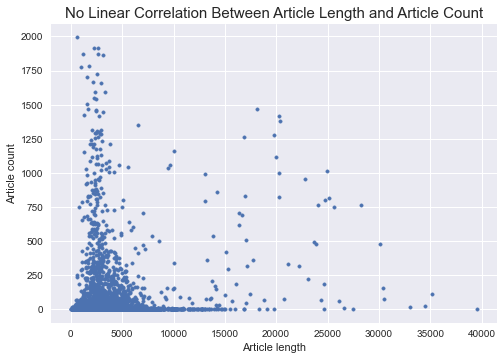

In [155]:
x = df2.avg_len
y = df2.article_count
plt.scatter(x[y<2000], y[y<2000], marker='.')
plt.ylabel("Article count")
plt.xlabel("Article length")

x = x.to_numpy(dtype=float)
y = y.to_numpy(dtype=float)
x = np.nan_to_num(x)
y = np.nan_to_num(y)

corr = pearsonr(x,y)[0]
print("Pearsin correlation:", corr)

plt.title("No Linear Correlation Between Article Length and Article Count", fontsize=15);

## No linear correlation...